# Chapter 10. Bifurcation Embedding

We now tackle the challenge of bifurcation embedding.
As an example, we verify that by learning the transients around fixed points, it is possible to extrapolate the emergence of the Lorenz attractor<sup>[1]</sup>.

## Introduction

### Overview of the Lorenz system

First, we provide an overview of the Lorenz system<sup>[2]</sup>, focusing on the bifurcation phenomena that are the main focus of this chapter.
The Lorenz system is described by the following differential equations:

$$
\begin{align*}
\frac{d x_1}{d t} &= a(x_2 - x_1) \\
\frac{d x_2}{d t} &= x_1(b - x_3) - x_2 \\
\frac{d x_3}{d t} &= x_1 x_2 - cx_3
.\end{align*}
$$

- $x_1, x_2, x_3 \in \mathbb{R}$: System state
- $a, b, c \in \mathbb{R}$: Parameters (constants)

With the representative parameter values $(a, b, c) = (10, 28, 8/3)$, a butterfly-shaped strange attractor is formed.
The qualitative change in the dynamics of a dynamical system when parameters are varied is called a **bifurcation**.
In this chapter, we fix $(a, c) = (10, 8/3)$ and focus on the bifurcations that occur when $b$ is varied.

The basic properties of this system are as follows:

- Invariance under the transformation $(x_1, x_2, x_3) \mapsto (-x_1, -x_2, x_3)$
- Three equilibrium points: $O$, $C$, and $C'$

The equilibrium points $C$ and $C'$ are located at the centers of the "wings" of the butterfly-shaped strange attractor.
In other words, the strange attractor of the Lorenz system forms under the influence of these three equilibrium points.
The changes in the stability of $O$, $C$, $C'$, and the strange attractor as the parameter $b > 0$ is varied are summarized in the following figure<sup>[3]</sup>.

<div style="text-align: center; width: 750px; margin: auto; background-color: #f8f9fa; padding: 10px; border-radius: 10px;">

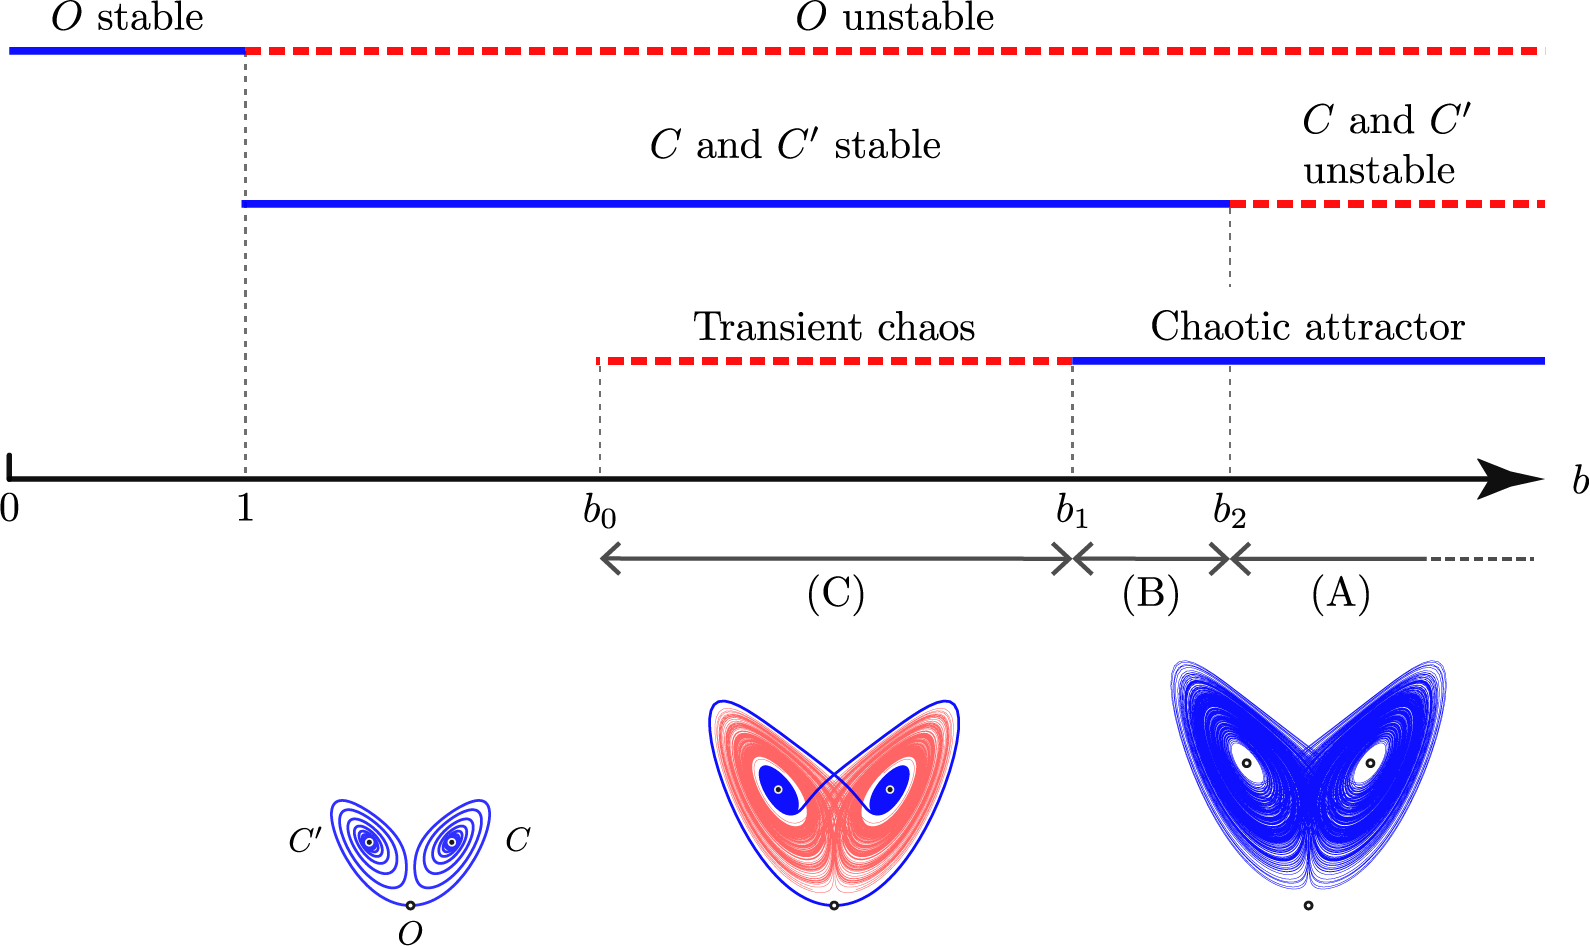
</div>

<figcaption align = "center">

Figure 1 Mechanism of bifurcation in the Lorenz system.

</figcaption>

Consider the situation where the parameter $b$ is gradually decreased from $b = 28$.

(A) For $b > b_2 \simeq 24.74$, the points $C$ and $C'$ are unstable, and the system has only a strange attractor.

(B) At $b = b_2$, $C$ and $C'$ become stable and act as fixed-point attractors.
Therefore, in the range $b_2 > b > b_1 \simeq 24.06$, both the strange attractor and the fixed-point attractors coexist in phase space.

(C) At $b = b_1$, the strange attractor comes into contact with the basin of attraction of the fixed-point attractors.
Trajectories that remain on the strange attractor for $b > b_1$ now show similar behavior for a finite time before being attracted to either $C$ or $C'$ when $b_1 > b > b_0 \simeq 13.93$.
This non-attractor structure is called **transient chaos**.

Let's observe the behavior of transient chaos in practice.

## Exercises and demonstrations

Now let's move on to the exercises and demonstrations.
Execute the following cell to import the classes that we implemented previously.
You can check the internal implementations either by uncommenting the lines after `import inspect` or by using `...?? / ??...`.

In [ ]:
import sys

import numpy as np

if "google.colab" in sys.modules:
    from google.colab import drive  # type: ignore

    if False:  # Set to True if you want to use Google Drive and save your work there.
        drive.mount("/content/gdrive")
        %cd /content/gdrive/My Drive/rc-bootcamp/
        # NOTE: Change it to your own path if you put the zip file elsewhere.
        # e.g., %cd /content/gdrive/My Drive/[PATH_TO_EXTRACT]/rc-bootcamp/
    else:
        pass
        %cd /content/
        !git clone --branch en_sol https://github.com/rc-bootcamp/rc-bootcamp.git
        %cd /content/rc-bootcamp/
else:
    sys.path.append(".")

from utils.chaos import lorenz_func, runge_kutta
from utils.reservoir import ESN, Linear, RidgeReadout
from utils.style_config import plt
from utils.tester import load_from_chapter_name
from utils.tqdm import trange
from utils.viewer import show_3d_coord, show_record

test_func, show_solution = load_from_chapter_name("10_bifurcation_embedding")

# Uncomment it to see the implementations.
# import inspect
# print(inspect.getsource(Linear))
# print(inspect.getsource(ReReadout))
# print(inspect.getsource(ESN))

# Or just use ??.../...?? (uncomment the following lines).
# Linear??
# RidgeReadout??
# ESN??
# runge_kutta??
# lorenz_func??

First, let's generate trajectories of the Lorenz system and observe how the attractor changes with different values of $b$.
We prepare two parameter values: $b = 23$ and $b = 28$.

In [ ]:
dt = 0.01
time_steps = 30000
z0 = np.array([3.0, 3.0, 3.0])[np.newaxis]
lorenz_func_rk4 = runge_kutta(dt, lorenz_func, b=np.array([23, 28]))

ds_test = np.zeros((time_steps + 1, 2, 3))
ds_test[0] = z0
for idx in trange(time_steps):
    ds_test[idx + 1] = lorenz_func_rk4(ds_test[idx])

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 4))
ax[0].plot(ds_test[:, 0, 0], lw=0.5)
ax[1].plot(ds_test[:, 1, 0], lw=0.5)
ax[0].set_ylabel(r"$b=23$")
ax[1].set_ylabel(r"$b=28$")

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))
ax[0].plot(*ds_test[:, 0, [0, 2]].T, lw=0.5)
ax[1].plot(*ds_test[:, 1, [0, 2]].T, lw=0.5)
ax[0].set_title(r"$b=23$")
ax[1].set_title(r"$b=28$")

None

Both exhibit butterfly-shaped dynamics, but for $b=23$, we observe attraction to a fixed-point attractor.

### Generation of training data

In this bifurcation embedding task, we learn the trajectories (transients) attracted to the fixed points $C$ and $C'$ under the condition $b_1 > b > b_0$ (C) and extrapolate the emergence of the strange attractor for $b > b_1$ (conditions A and B).

Following the original paper, we use $b = 23$ and $24$ as training points and ensure that the target time series do not include butterfly-shaped transient chaos.
Setting the initial conditions as shown below yields appropriate target trajectories.
Furthermore, we can augment the training data by exploiting the system's symmetry.

In [ ]:
dt = 0.01
time_steps = 20000
z0 = np.array([4e-3, 9e-3, 0])[np.newaxis]
lorenz_func_rk4 = runge_kutta(dt, lorenz_func, b=np.array([23, 24]))

ds_raw = np.zeros((time_steps + 1, 2, 3))
ds_raw[0] = z0
for idx in trange(time_steps):
    ds_raw[idx + 1] = lorenz_func_rk4(ds_raw[idx])

ds = np.stack(
    [
        ds_raw[:, 0],  # b = 23
        ds_raw[:, 0] * np.array([-1, -1, 1]),  # b = 23
        ds_raw[:, 1],  # b = 24
        ds_raw[:, 1] * np.array([-1, -1, 1]),
    ],
    axis=1,
)  # b = 24

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 4))
ax[0].plot(ds[:, 0, 0], lw=0.5)
ax[1].plot(ds[:, 2, 0], lw=0.5)
ax[0].set_ylabel(r"$b=23$")
ax[1].set_ylabel(r"$b=24$")

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))
ax[0].plot(*ds[:, 0, [0, 2]].T, lw=0.5)
ax[0].plot(*ds[:, 1, [0, 2]].T, lw=0.5)
ax[1].plot(*ds[:, 2, [0, 2]].T, lw=0.5)
ax[1].plot(*ds[:, 3, [0, 2]].T, lw=0.5)
ax[0].set_title(r"$b=23$")
ax[1].set_title(r"$b=24$")

None

### Parameter-aware RC

In bifurcation embedding, we use an ESN with a **parameter channel** $W^\mathrm{param}$, which takes the control parameter $u^{(i)}$ associated with the teacher signal $y^{(i)}[k]$ as input.
This architecture is called **parameter-aware reservoir computing (PARC)**.
Let us design a following closed-loop system that generates the trajectories for $b = 23$ and $b = 24$ when $u = 0$ and $u = 1$, respectively:

$$
\begin{align*}
{x}[k+1] &= (1-a){x}[k]+a\tanh\left(\rho W^\text{rec} {x}[k] + W^\mathrm{feed}{y}^{(i)}[k] + W^\mathrm{param} u^{(i)}\right)\\
{y}[k] &= W^{\text{out}} {x}[k]
.\end{align*}
$$

Q1.1.

Fill in the blanks below to complete `emulate_with_control`, which records the time series of an ESN with control input.
Note that the system switches to open-loop mode $x[k+1] = f(x[k], d[k]; u[k])$ for $k \in [k_0, k_1)$, and the semi-closed-loop mode $x[k+1] = f(x[k], W^\mathrm{out} x[k]; u[k])$ otherwise.

- `emulate_with_control`:
  - Argument(s):
    - `time_steps`: `int`
      - $T$
    - `x0`: `np.ndarray`
      - $x[0]$
    - `net`: `ESN`
    - `w_feed`: `Linear | RidgeReadout`
      - $W^\mathrm{feed}$
    - `w_param`: `Linear | RidgeReadout`
      - $W^\mathrm{param}$
    - `w_out`: `Linear | RidgeReadout`
      - $W^\mathrm{out}$
    - `ds`: `np.ndarray`
      - `shape`: `(t, k, dim_in)`
    - `us`: `np.ndarray`
      - `shape`: `(t, k, 1)`
    - `open_range`: `tuple(int, int)`
      - $[t_\mathrm{b}, t_\mathrm{e})$
  - Return(s):
    - `record`: `dict`
      - `'t'`: `np.ndarray`
        - $[0, 1,~\ldots,~T-1, T]$
      - `'x'`: `np.ndarray`
        - $[x[0], x[1],~\ldots,~x[T-1], x[T]]$
      - `'y'`: `np.ndarray`
        - $[y[0], y[1],~\ldots,~y[T-1]]$

<details><summary>tips</summary>

- When `ds` is `None` and $t \in [t_\mathrm{b}, t_\mathrm{e})$, the system will feed the output `y` back into the system.
- Otherwise, it will use `ds[idx]`.

</details>

In [ ]:
def emulate_with_control(
    time_steps,
    x0,
    net,
    w_feed,
    w_param,
    w_out,
    us,
    ds=None,
    open_range=None,
    label=None,
    display=True,
    save_x=True,
):
    open_range = open_range if open_range is not None else [0, 0]
    record = {}
    record["t"] = np.arange(0, time_steps + 1)
    record["y"] = np.zeros((time_steps, *w_out(x0).shape))
    record["open_range"] = open_range
    x = x0
    if save_x:
        record["x"] = np.zeros((time_steps + 1, *x0.shape))
        record["x"][0] = x0
    pbar = trange(time_steps, display=display)
    for idx in pbar:
        if label is not None:
            pbar.set_description(label)
        if (ds is not None) and (idx < len(ds)) and (open_range[0] <= idx < open_range[1]):
            y = ds[idx]  # TODO Training phase (i.e., teacher forcing by `ds`)
        else:
            y = w_out(x)  # TODO Evaluation phase (i.e., autonomous closed-loop mode by `w_out`)
        u = us[idx]  # TODO u[k]
        x = net(x, w_feed(y) + w_param(u))  # TODO Implement x[k + 1] = f(x[k], y[k], u[k])
        record["y"][idx] = y
        if save_x:
            record["x"][idx + 1] = x
    return record


def solution(*args, **kwargs):
    record = emulate_with_control(*args, **kwargs)
    return record["x"], record["y"]


test_func(solution, "01_01", multiple_output=True)
# show_solution("01_01", "emulate_with_control")  # Uncomment it to see the solution.

Let's collect time-series data using the implemented `emulate_with_control` and train $W^\mathrm{out}$ based on that data.
The following question implements the function `run_train_and_eval` to perform this task.

Q1.2.

Implement `run_train_and_eval` to perform the learning procedures of the training and evaluation phases.

- `run_train_and_eval`:
  - Argument(s):
    - `t_washout, t_train, t_eval`: `int`
      - $T_\mathrm{washout}, T_\mathrm{train}, T_\mathrm{eval}$
    - `x0`: `np.ndarray`
      - $x[0]$
    - `net`: `ESN`
    - `w_feed`: `Linear | RidgeReadout`
      - $W^\mathrm{feed}$
    - `w_param`: `Linear | RidgeReadout`
      - $W^\mathrm{param}$
    - `w_out`: `Linear | RidgeReadout`
      - $W^\mathrm{out}$
    - `ds`: `np.ndarray`
      - $[d[0], d[1], \ldots]$
    - `us`: `np.ndarray`
      - $[u[0], u[1], \ldots]$

  - Return(s):
    - `record_t`: `dict`
      - training data
    - `record_e`: `dict`
      - evaluation data

In [ ]:
def run_train_and_eval(t_washout, t_train, t_eval, x0, net, w_feed, w_param, w_out, us, ds, display=True):
    # Training phase (open loop)
    record_t = emulate_with_control(
        t_washout + t_train,
        x0,
        net,
        w_feed,
        w_param,
        w_out,
        us,
        ds,
        open_range=[0, t_washout + t_train],
        label="Train",
        display=display,
    )

    # Run ridge regression and update of `w_out`
    x_train = record_t["x"][t_washout : t_washout + t_train]  # t \in [t_washout, t_washout + t_train)
    y_train = record_t["y"][t_washout : t_washout + t_train]  # t \in [t_washout, t_washout + t_train)
    y_eval = ds[t_washout + t_train : t_washout + t_train + t_eval]

    w_out.train(
        # TODO Update `w_out` with `x_train` and `y_train`.
        x_train.reshape(-1, w_out.input_dim),
        y_train.reshape(-1, w_out.output_dim),
        # end of TODO
    )

    # Evaluation phase (closed loop)
    x1 = np.array(record_t["x"][-1])
    record_e = emulate_with_control(t_eval, x1, net, w_feed, w_param, w_out, us=us, label="Eval", display=display)
    record_e["d"] = y_eval
    return record_t, record_e


def solution(*args, **kwargs):
    # DO NOT CHANGE HERE.
    _record_t, record_e = run_train_and_eval(*args, **kwargs)
    return record_e["x"], record_e["y"]


test_func(solution, "01_02", multiple_output=True)
# show_solution("01_02", "run_train_and_eval")  # Uncomment it to see the solution.

Now, let's train a PARC to reproduce the transients `ds` around the fixed points of the Lorenz system at $b = 23$ and $b = 24$ using control inputs $u = 0$ and $u = 1$, respectively.

In [ ]:
seed = 1234
rnd = np.random.default_rng(seed)

net_dim = 500
out_dim = 3
t_washout, t_train, t_eval = 2000, 2500, 5000

net = ESN(net_dim, sr=0.7, p=0.1, a=0.5, rnd=rnd)

w_feed = Linear(out_dim, net_dim, bound=0.025, bias=1.0, rnd=rnd)
w_param = Linear(1, net_dim, bound=0.01, bias=0, rnd=rnd)
w_out = RidgeReadout(
    net_dim, out_dim, lmbd=0, rnd=rnd
)  # Set positive value to alpha (e.g., alpha=1e-6) if output is unstable.

# Create control input.
us = np.zeros((len(ds), 4, 1))
us[:, 2:] = 1

x0 = rnd.uniform(-1, 1, (4, net_dim))
rec_lz_t, record_e = run_train_and_eval(t_washout, t_train, t_eval, x0, net, w_feed, w_param, w_out, us, ds)

The following cell shows the output of the closed-loop PARC trained on trajectories at $b = 23$ and $b = 24$ (dotted lines represent teacher signals).

In [ ]:
fig_t = show_record(record_e, ["y"], view_slice=(..., 0))
fig_t[0].set_title("u=0 (b=23)")
fig_e = show_record(record_e, ["y"], view_slice=(..., 1))
fig_e[0].set_title("u=1 (b=24)")

None

Let's also check the trajectory on the $xz$ plane.

In [ ]:
fig, ax = plt.subplots(figsize=[6, 3])
ax.plot(*record_e["y"][:, 0, [0, 2]].T, lw=1, label="$u=0$")
ax.plot(*record_e["y"][:, 3, [0, 2]].T, lw=1, label="$u=1$")
fig.legend(loc="lower center", bbox_to_anchor=(0.5, 0.9), ncol=2)
# fig.tight_layout()

None

The trained model successfully outputs the transients around the fixed points at $b = 23$ and $b = 24$ under control inputs $u = 0$ and $u = 1$, respectively.
What happens if we set $u = 5$?

In [ ]:
x1 = np.array(rec_lz_t["x"][-1, 0])
record_ex = emulate_with_control(
    10000, x1, net, w_feed, w_param, w_out, us=np.ones((10000, 1)) * 5, label="Eval", display=True, save_x=False
)

fig, ax = plt.subplots(figsize=[5, 5])
ax.plot(*record_ex["y"][:, [0, 2]].T, lw=1)

None

The strange attractor is successfully reproduced.
Let's visualize everything together, including the transient chaos.

In [ ]:
fig = show_3d_coord(
    b23=ds[:, 0],  # Lorenz: b=23
    u0=record_e["y"][:, 0],  # RC: u=0
    b24=ds[:, 3],  # Lorenz: b=24
    u1=record_e["y"][:, 3],  # RC: u=1
    b28=ds_test[:, 1],  # Lorenz: b=28
    u5=record_ex["y"],  # RC: u=5
)
fig.show()

With $u = 5$, a strange attractor similar to that observed at $b = 28$ emerges.
This behavior is not explicitly included in the training data `ds`, indicating that the bifurcation has been extrapolated.

Q1.3. (Advanced)

- The following program plots the local maxima of $z$ for the Lorenz system and the trained PARC system over the ranges $b \in [23, 28]$ and $c \in [0, 5]$, respectively, to compare their bifurcation diagrams.
Run the program below and compare the two systems.
- You will see that the bifurcation point from the non-chaotic to the chaotic region is shifted.
Increase the number of data points and observe how this bifurcation changes.

In [ ]:
# Lorenz
dt = 0.01
discard = 30000
length = 10000
num_param = 141
bs_bif = np.linspace(22, 29, num_param)
z0s = np.stack(
    [
        np.sqrt(8 / 3 * (bs_bif - 1)) + 1,
        np.sqrt(8 / 3 * (bs_bif - 1)) + 1,
        bs_bif - 1 + 1,
    ],
    axis=-1,
)
lorenz_func_rk4 = runge_kutta(dt, lorenz_func, b=bs_bif)

target_bif = np.zeros((length, num_param, 3))
zs = z0s
for idx in trange(discard + length):
    zs = lorenz_func_rk4(zs)
    if idx >= discard:
        target_bif[idx - discard] = zs

The following code samples trajectories for `num_param` different values of the parameter $b$.
By default, `num_param=141`, but you can reduce this if the execution takes too long.

In [ ]:
# PARC
x0s = record_e["x"][-1, -1][np.newaxis].repeat(num_param, 0)
us_bif = np.linspace(-1, 6, num_param)[np.newaxis, :, np.newaxis].repeat(discard + length, 0)

record_bif = emulate_with_control(discard + length, x0s, net, w_feed, w_param, w_out, us_bif, save_x=False)

The following cell plots the bifurcation diagrams for both systems for comparison.
At this point, you may notice some discrepancies.

In [ ]:
import scipy as sp

fig, ax = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True)

for idx, b in enumerate(bs_bif):
    id_maxima = sp.signal.find_peaks(target_bif[:, idx, 2])[0]
    peaks = target_bif[:, idx, 2][id_maxima]
    ax[0].scatter(b * np.ones(peaks.shape[0]), peaks, marker=".", s=1.0, color="black")
ax[0].set_ylim(19, 51)
ax[0].set_xlim(bs_bif[0], bs_bif[-1])
ax[0].set_xlabel(r"$b$")
ax[0].set_ylabel("Lorenz")
for pos in [23.0, 24.0]:
    ax[0].axvline(pos, color="blue", lw=1.0, ls="--")

for idx, u in enumerate(us_bif[0]):
    id_maxima = sp.signal.find_peaks(record_bif["y"][discard:, idx, 2])[0]
    peaks = record_bif["y"][discard:, idx, 2][id_maxima]
    ax[1].scatter(u * np.ones(peaks.shape[0]), peaks, marker=".", s=1.0, color="red")
ax[1].set_ylim(19, 51)
ax[1].set_xlim(us_bif[0, 0], us_bif[0, -1])
ax[1].set_xlabel(r"$u$")
ax[1].set_ylabel("PARC")
for pos in [0.0, 1.0]:
    ax[1].axvline(pos, color="blue", lw=1.0, ls="--")

## References

[1] Lorenz, E. N. (1963). *Deterministic Nonperiodic Flow*. https://doi.org/10.1175/1520-0469(1963)020%3C0130:DNF%3E2.0.CO;2

[2] Kim, J.Z., Lu, Z., Nozari, E., Pappas, G.J., Bassett, D.S., (2021). *Teaching recurrent neural networks to infer global temporal structure from local examples*. Nature Machine Intelligence 3(4), 316–323. https://doi.org/10.1038/s42256-021-00321-2

[3] Ott, E. (2002). *Chaos in dynamical systems*. Cambridge university press. https://doi.org/10.1017/CBO9780511803260

[4] Yorke, J. A., & Yorke, E. D. (1979). *Metastable chaos: The transition to sustained chaotic behavior in the Lorenz model*. Journal of Statistical Physics, 21(3), 263–277. https://doi.org/10.1007/BF01011469